In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import cufflinks as cf
import cv2
import nltk
import string


from chart_studio import plotly as py 
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from pandas_datareader import data,wb
from nltk.corpus import stopwords

%matplotlib inline

Data Gathering

In [212]:
yelp = pd.read_csv(r".\data\yelp.csv")

In [213]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


Data Processing

In [214]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [215]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [216]:
yelp["text length"] = yelp["text"].apply(len)

In [217]:
sns.set_style("white")

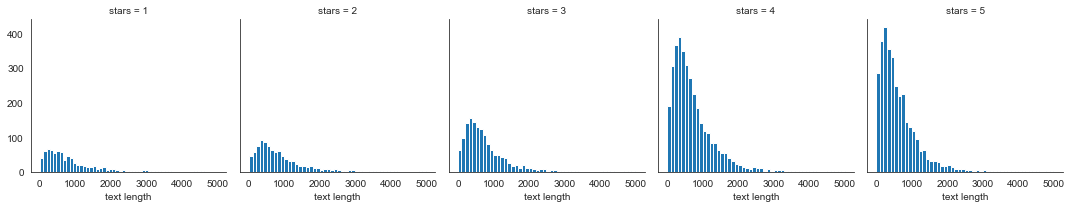

In [218]:
g = sns.FacetGrid(yelp,col="stars")
g.map(plt.hist,'text length', bins=50)

<AxesSubplot:xlabel='stars', ylabel='text length'>

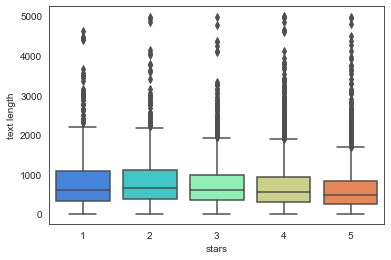

In [219]:
sns.boxplot(x='stars',y='text length',data=yelp,palette="rainbow")

<AxesSubplot:xlabel='stars', ylabel='count'>

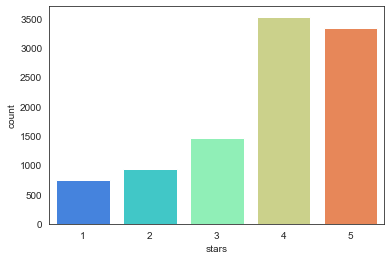

In [220]:
sns.countplot(data=yelp, x='stars', palette="rainbow")

In [221]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [222]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


<AxesSubplot:>

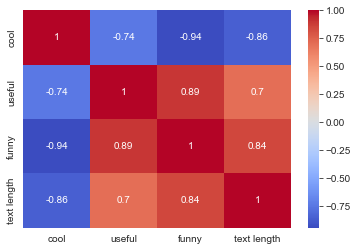

In [223]:
sns.heatmap(stars.corr(), cmap="coolwarm", annot=True)

NLP Classification Task

In [224]:
yelp_class = yelp[(yelp['stars']==1) | (yelp['stars']==5)]

In [225]:
yelp_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4086 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  4086 non-null   object
 1   date         4086 non-null   object
 2   review_id    4086 non-null   object
 3   stars        4086 non-null   int64 
 4   text         4086 non-null   object
 5   type         4086 non-null   object
 6   user_id      4086 non-null   object
 7   cool         4086 non-null   int64 
 8   useful       4086 non-null   int64 
 9   funny        4086 non-null   int64 
 10  text length  4086 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 383.1+ KB


Feature Selections

In [226]:
feature = yelp_class['text']
target = yelp_class['stars']

In [227]:
from sklearn.feature_extraction.text import CountVectorizer
Count_model = CountVectorizer()
feature = Count_model.fit_transform(feature)

Train Test split

In [228]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(feature,target, test_size=0.3, random_state=101)

Modeling

In [229]:
from sklearn.naive_bayes import MultinomialNB
Multi_model = MultinomialNB()
Multi_model.fit(xtrain,ytrain)

MultinomialNB()

Predictions and Evaluations

In [230]:
predictions = Multi_model.predict(xtest)

Cross Metrix

In [231]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(ytest,predictions))
print(classification_report(ytest,predictions))

[[159  69]
 [ 22 976]]
              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226



Using Text Processing

In [232]:
from sklearn.feature_extraction.text import TfidfTransformer

In [233]:
from sklearn.pipeline import Pipeline
pipe_model = Pipeline([('bow',CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('model',MultinomialNB())
])

In [234]:
pipe_model.fit(xtrain,ytrain.values.ravel())

AttributeError: lower not found

Prediction and Evaluations

In [ ]:
predictions2 = pipe_model.predict(xtest) 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(ytest,predictions2))
print(classification_report(ytest,predictions2))

[[  0 228]
 [  0 998]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       228
           5       0.81      1.00      0.90       998

    accuracy                           0.81      1226
   macro avg       0.41      0.50      0.45      1226
weighted avg       0.66      0.81      0.73      1226



C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

